<hr style="border:5px solid orange"> </hr>

# Neural Networks

## DS 420 Lecture 8

Outline of lab:

 - Illustration of perceptron gates

 - Applying 2 layer "logistic regression" neural network to data.
 
 - Sk-Learn implementations.
 
 - Tensorflow-Keras implementations.


<hr style="border:5px solid orange"> </hr>

In [1]:
import time
import numpy as np

import matplotlib.pyplot as plt

<hr style="border:3px solid orange"> </hr>

## Consider Single Circuit:

Single circuit with one gate:

```
x--->  ______
      |      |
      | (*)  |===> (x * y)
y---> |______|
```

In [2]:
def forward_multiply(x1, x2):
    return x1 * x2

print(forward_multiply(3, 4))

12


Now how do we decrease the output? Intuitively we can just decrease the inputs.

In [3]:
print(forward_multiply(2.9, 4))

11.6


But not all gates are that simple. To answer tihs question, we need to use the "derivative". This will tell us *which* direction to change the inputs to change the outputs.

In general the derivative of a function, $f(x, y, z, ...)$ with respect to $x$ is:

$$
\frac{df(x, ...)}{dx} = \lim_{h \to 0} \frac{f(x+h, ...) - f(x, ...)}{h}
$$

Above, our multiply function is $f(x,y)=x*y)$. The derivative is:

$$
\frac{df(x,y)}{dx} = \frac{(x+h)*y - x*y}{h} = y
$$

> Note: Don't worry too much about this, we can always evaluate derivatives numerically (see below).

In [4]:
x = 3
y = 4
h_seq = [0.01, 0.001, 0.0001, 0.00001]

for h in h_seq:
    num_derivative = (forward_multiply(x+h, y) - forward_multiply(x, y)) / h
    print('h={}, then df/dx={}'.format(h, num_derivative))

h=0.01, then df/dx=3.9999999999999147
h=0.001, then df/dx=3.9999999999995595
h=0.0001, then df/dx=4.000000000008441
h=1e-05, then df/dx=4.000000000026205


### Derivative of Multiplication function:

So for `x=3` and `y=4`, the derivative with respect to x was 4.

Just play around with the numbers, you'll easily find that:

$$
\frac{df}{dx}=y
$$

and because what we choose for x and y are arbitrary ($x*y=y*x$):

$$
\frac{df}{dy}=x
$$

In [5]:
# Shortcut:
def mult_gradient_x(x, y):
    return y

def mult_gradient_y(x, y):
    return x

<hr style="border:3px solid orange"> </hr>

## Decreasing the Output of the Single-Gate Network

Let's loop and decrease the output slowly:

In [6]:
num_loops = 100
step_size = 0.001
start_x = x
start_y = y
best_x = x
best_y = y
best_result = x*y

for i in range(num_loops):
    x = x - (step_size * mult_gradient_x(x, y))
    y = y - (step_size * mult_gradient_y(x, y))
    result = x * y
    
    # Check if we got lower, then that's better and save results
    if result < best_result:
        best_x = x
        best_y = y
        best_result = x * y
    print(result)
    time.sleep(0.05)

# Print results
print('Starting Values- x={}, y={}, result={}'.format(start_x, start_y, start_x*start_y))
print('Final Values- x={}, y={}, result={}'.format(best_x, best_y, best_result))

11.975023984
11.95009586109591
11.925215531575216
11.900382895916573
11.875597854789415
11.85086030905355
11.826170159758773
11.801527308144463
11.776931655639183
11.752383103860307
11.727881554613596
11.703426909892832
11.679019071879411
11.654657942941954
11.630343425635926
11.60607542270323
11.58185383707183
11.557678571855362
11.533549530352738
11.50946661604777
11.485429732608777
11.461438783888198
11.437493673922216
11.413594306930367
11.38974058731516
11.365932419661691
11.342169708737268
11.31845235949102
11.29478027705353
11.271153366736442
11.247571534032094
11.224034684613128
11.200542724332125
11.177095559221222
11.153693095491729
11.130335239533775
11.107021897915908
11.08375297738474
11.060528384864567
11.037348027456991
11.014211812440562
10.991119647270398
10.968071439577816
10.945067097169957
10.922106528029433
10.899189640313944
10.876316342355915
10.853486542662132
10.830700149913374
10.807957072964046
10.785257220841817
10.762600502747258
10.739986828053471
10.71741

<hr style="border:3px solid orange"> </hr>

## Multiple Gates

Consider:

$
f(x, y, z) = (x + y) * z
$

OR

$
g(x, y) = x + y
$

and

$
f(x, y, z) = g(x, y) * z = g* z
$

Which looks like:

```
x--->  ______
      |      |
      | (+)  |
y---> |______|---> ______
                  |      |
                  | (*)  |===> (x + y) * z
z---------------->|______|
```

In [7]:
# Let's define the relevant new functions:

def forward_add(x1, x2):
    return x1 + x2

In [8]:
def forward_two_gate(x, y, z):
    out1 = forward_add(x, y)
    out2 = forward_multiply(out1, z)
    
    return out1

### Derivative of Addition

Turns out they are the same for both variables:

$
\frac{df}{dx} = \frac{df}{dy} = 1
$

In [9]:
def add_gradient(x1, x2):
    return 1

### Derivative of full 2 operation gate:

We call these operations (`+` then `*`) "chained together". So we use something called the chain rule for derivatives:

$$
\frac{df(x, y, z)}{dx} = \frac{dg}{dx} * \frac{df}{dg}
$$

Now let's consider reducing the output of the larger gate by looping through a fixed number of times:

In [10]:
num_loops = 100
step_size = 0.01
x = 2
y = 3
z = 4
start_x = x
start_y = y
start_z = z
best_x = x
best_y = y
best_z = z
best_result = (x + y) * z

# Save result for later
saved_results = []

for i in range(num_loops):
    # temporarily store the first output (need it later)
    out1_temp = forward_add(x, y)
    x = x - (step_size * add_gradient(x, y) * mult_gradient_x(out1_temp, z))
    y = y - (step_size * add_gradient(x, y) * mult_gradient_x(out1_temp, z))
    z = z - (step_size * mult_gradient_y(out1_temp, z))
    result = (x + y) * z
    
    # Check if we got lower, then that's better and save results
    if result < best_result:
        best_x = x
        best_y = y
        best_z = z
        best_result = (x + y) * z
        saved_results.append(best_result)
    print(result)
    time.sleep(0.05)

# Print results
print('Starting Values- x={}, y={}, z={}, result={}'.format(start_x, start_y, start_z, start_x*start_y))
print('Final Values- x={}, y={}, z={}, result={}'.format(best_x, best_y, best_z, best_result))

19.434
18.883772800000003
18.34887193176
17.828863366061796
17.323325160527837
16.831847117249982
16.35403044995023
15.889487460403474
15.437841223859643
14.998725283210018
14.571783351649572
14.156669023594059
13.75304549361731
13.360585283180683
12.978969974932955
12.607889954365065
12.247044158610091
11.896139832184708
11.55489228947388
11.223024683766122
10.900267782651966
10.58635974960339
10.281045931557008
9.984078652328698
9.695217011692106
9.414226689957975
9.140879757895823
8.874954491843745
8.616235193856374
8.364512016745103
8.119580793868666
7.881242873535992
7.649304957887047
7.4235789461209585
7.203881781944273
6.990035305115659
6.781866106966595
6.5792053897809515
6.381888829919364
6.18975644457744
6.002652462069762
5.820425195534487
5.642926919956153
5.470013752407007
5.301545535409731
5.13738572332703
4.977401271686004
4.821462529347554
4.669443133433465
4.521219906925989
4.37667275885693
4.235684587005389
4.098141183025282
3.9639311399258044
3.8329457618298592
3.7050

### What happens if we increase the stepsize to something larger?

In [11]:
original_results = saved_results
# Change step size to 5.0

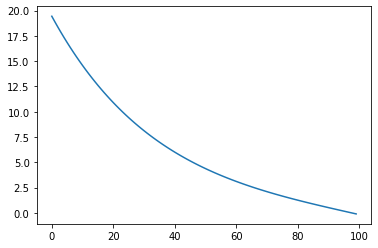

In [12]:
# Plot both results
plt.plot(original_results)

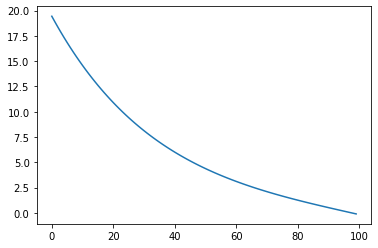

In [13]:
plt.plot(saved_results)

# Now only plot the first few if the numbers are too negative:
# plt.plot(saved_results[:2])

## What happened?

Both graphs make a point:

1. Notice the first graph and the slight curve to it. The line seems to get gradually less steep. This is because of our gradient. As the values of the outputs get closer to zero (smaller), this affects the outputs.

2. Imagine we take too big of a step and make all our values negative (x + y) * z will be very positive. This keeps happening until x and y get too large and the gradient can make one negative and one positive. then it can get a very small number.

> This type of behavior is common to see in neural networks. They are very sensitive to some hyperparameters and can have trouble optimizing if we set the wrong values.


<hr style="border:3px solid orange"> </hr>

## Pursue a Goal/Target Value

We can make our circuit lower or increase the output value. Let's make it persue a specific numerical target.

Our goal will be to decrease this network until it gets to the value 17.

In [14]:
num_loops = 100
goal = 17
step_size = 0.05
x = 2
y = 3
z = 4
start_x = x
start_y = y
start_z = z
best_x = x
best_y = y
best_z = z
best_result = (x + y) * z

# Let's save how far away we are from our goal, call it the "loss".
loss_vec = []

for i in range(num_loops):
    # temporarily store the first output (need it later)
    out1_temp = forward_add(x, y)
    out2_temp = forward_multiply(out1_temp, z)
    
    # Now we need to measure the "loss", or the distance between our prediction and our goal.
    #  - If the loss is negative (under predict), we increase our values.
    #  - If the loss is positive (over predict), we decrease out values.
    loss = out2_temp - goal
    loss_vec.append(loss)
    if loss > 0:
        sign_of_change = -1
    else:
        sign_of_change = 1
    
    # Update inputs accordingly.
    x = x + sign_of_change * (step_size * add_gradient(x, y) * mult_gradient_x(out1_temp, z))
    y = y + sign_of_change * (step_size * add_gradient(x, y) * mult_gradient_x(out1_temp, z))
    z = z + sign_of_change * (step_size * mult_gradient_y(out1_temp, z))
    result = (x + y) * z
    
    # Check if we got lower, then that's better and save results
    if result < best_result:
        best_x = x
        best_y = y
        best_z = z
        best_result = (x + y) * z
        saved_results.append(best_result)
    print(result)
    time.sleep(0.05)

# Print results
print('Starting Values- x={}, y={}, z={}, result={}'.format(start_x, start_y, start_z, start_x*start_y))
print('Final Values- x={}, y={}, z={}, result={}'.format(best_x, best_y, best_z, best_result))

17.25
14.871999999999998
17.07793125
14.7236518
16.907578885781252
19.407450187125317
16.738925786395583
19.21386087150874
16.571955001676287
19.022202609315443
16.40664975053457
18.83245613828752
16.242993419272985
18.6446023883081
16.08096955991574
18.45862247948473
15.920561888555579
18.27449772025187
15.761754283717238
18.092209605492354
15.60453078473716
17.911739814677567
15.448875590159403
17.73307021002616
15.294773056147562
17.556182834681145
15.142207694912491
17.381059910905204
14.991164173155738
17.207683838293928
14.84162731052851
17.036037192006944
14.69358207810599
16.866102721016677
19.353852872366634
16.697863346374533
19.160798189964776
16.531302159494444
18.969669228019878
16.366402420453486
18.780446777470377
16.203147556309464
18.593111820865108
16.041521159435277
18.40764553045198
15.881506985869908
18.224029266285722
15.72308895368586
18.042244574354523
15.566251141372842
17.862273184725336
15.410977786237648
17.6840970097077
15.257253282819924
17.507698142035863

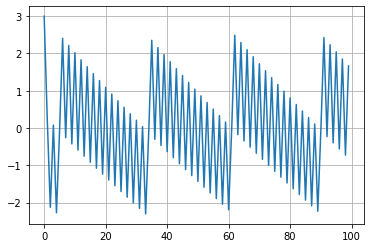

In [15]:
# Plot loss values
plt.plot(loss_vec)
plt.grid()

### What is happening? Is this a problem.

Redo all of this with a larger step size. Try 0.05.

### We can address this problem:

Let's change the step size based on how close we are to the goal:

In [16]:
num_loops = 1000
goal = 17
step_size = 0.001
x = 2
y = 3
z = 4
start_x = x
start_y = y
start_z = z
best_x = x
best_y = y
best_z = z
best_result = (x + y) * z

# Let's save how far away we are from our goal, call it the "loss".
loss_vec = []

for i in range(num_loops):
    # temporarily store the first output (need it later)
    out1_temp = forward_add(x, y)
    out2_temp = forward_multiply(out1_temp, z)
    
    # Now we need to measure the "loss", or the distance between our prediction and our goal.
    #  - If the loss is negative (under predict), we increase our values.
    #  - If the loss is positive (over predict), we decrease out values.
    loss = out2_temp - goal
    magnitude = loss**2
    loss_vec.append(loss)
    if loss > 0:
        sign_of_change = -1
    else:
        sign_of_change = 1
    
    # Update inputs accordingly.
    new_step = step_size * magnitude
    
    x = x + sign_of_change * (new_step * add_gradient(x, y) * mult_gradient_x(out1_temp, z))
    y = y + sign_of_change * (new_step * add_gradient(x, y) * mult_gradient_x(out1_temp, z))
    z = z + sign_of_change * (new_step * mult_gradient_y(out1_temp, z))
    result = (x + y) * z
    
    # Check if we got lower, then that's better and save results
    if result < best_result:
        best_x = x
        best_y = y
        best_z = z
        best_result = (x + y) * z
        saved_results.append(best_result)
#    print(result)
#    time.sleep(0.05)

# Print results
print('Starting Values- x={}, y={}, z={}, result={}'.format(start_x, start_y, start_z, start_x*start_y))
print('Final Values- x={}, y={}, z={}, result={}'.format(best_x, best_y, best_z, best_result))

Starting Values- x=2, y=3, z=4, result=6
Final Values- x=1.7816925983529197, y=2.781692598352921, z=3.7297359449064227, result=17.020221798607643


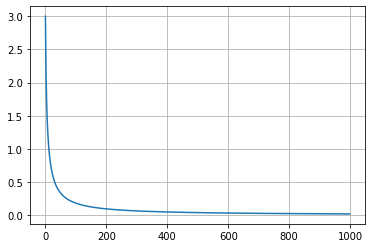

In [17]:
# Plot loss function
plt.plot(loss_vec)
plt.grid()

<hr style="border:3px solid orange"> </hr>

## Simple Neural Network

What we've done so far is VERY close to a neural network.  We just need to add a "sigmoid" function to the end of our outputs.

Sigmoid:

$$
\textrm{sigmoid}(x) = \frac{1}{1 + e^{-x}}
$$

Also, it turns out that the sigmoid has a really awesome property:

$$
\frac{d(\textrm{sigmoid}(x))}{dx} = \textrm{sigmoid}(x) * (1 - \textrm{sigmoid}(x))
$$

The derivative of the sigmoid is related to itself!


In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [19]:
# Test if neuron works:
def forward_neuron(x, a, b):
    out1 = forward_multiply(a, x)
    out2 = forward_add(out1, b)
    return sigmoid(out2)

# These should be equal:
print(forward_neuron(2, 2, 3))
print(1 / (1 + np.exp(-((2 * 2) + 3))))

0.9990889488055994
0.9990889488055994


## Decrease output of forward neuron.

Now we do the same thing, except we only vary `a` and `b`, keeping the same `x`.

In [20]:
# no goal this time
num_loops = 100
step_size = 0.01
a = 2
b = 3
x = 2
start_a = a
start_b = b

best_a = a
best_b = b

start_result = forward_neuron(x, a, b)
best_result = start_result

for i in range(num_loops):
    # Use chain rule
    a_gradient = d_sigmoid(a * x + b) * mult_gradient_x(x, a) * add_gradient(x*a, b)
    b_gradient = d_sigmoid(a * x + b) * add_gradient(x*a, b)
    
    a = a - (step_size * a_gradient)
    b = b - (step_size * b_gradient)
    result = forward_neuron(x, a, b)
    
    # Check if we got lower, then that's better and save results
    if result < best_result:
        best_a = a
        best_b = b
        best_result = result
        saved_results.append(best_result)
    print(result)
    time.sleep(0.05)

# Print results
print('Starting Values- a={}, b={}, result={}'.format(start_a, start_b, start_result))
print('Final Values- a={}, b={}, result={}'.format(best_a, best_b, best_result))

0.9990889073795286
0.9990888659499955
0.9990888245169995
0.9990887830805406
0.9990887416406177
0.9990887001972312
0.9990886587503801
0.999088617300064
0.9990885758462826
0.9990885343890357
0.9990884929283226
0.9990884514641432
0.9990884099964965
0.9990883685253824
0.9990883270508006
0.9990882855727508
0.9990882440912321
0.9990882026062443
0.9990881611177872
0.9990881196258601
0.9990880781304626
0.9990880366315944
0.9990879951292552
0.9990879536234442
0.9990879121141613
0.999087870601406
0.9990878290851778
0.9990877875654762
0.9990877460423012
0.9990877045156519
0.9990876629855281
0.9990876214519293
0.9990875799148551
0.9990875383743051
0.999087496830279
0.9990874552827762
0.9990874137317964
0.999087372177339
0.9990873306194038
0.99908728905799
0.9990872474930979
0.9990872059247262
0.999087164352875
0.999087122777544
0.9990870811987322
0.9990870396164399
0.9990869980306663
0.9990869564414108
0.9990869148486731
0.9990868732524529
0.9990868316527499
0.9990867900495635
0.9990867484428931
0

<hr style="border:3px solid orange"> </hr>

## Compare Different Neural Network Gates (Activations)

There are a few different standard neural network gates to use other than just the "sigmoid()".

### Rectified Linear Unit (ReLU)

$\textrm{ReLU}(x)=\textrm{max}(x, 0)$

### Softplus

$\textrm{Softplus}(x)=\log(1 + e^{x})$

### Leaky ReLU

Given $a < 1$,

$\textrm{Leaky ReLU}(x)=\textrm{max}(x, a*x)$

### Hyperbolic Tangent

$\textrm{Hyperbolic Tangent}(x) = tanh(x)$

<hr style="border:3px solid orange"> </hr>

## Perform a Simple Neural Network on a Binary Classifier w/ data.

Here will will mimic a simple neural network that samples data and tries to output a number between 0 and 1 for a binary classifier.

This data represents some demographic data in a hurricane prone location and the target is wether or not the occupant evacuated thier homes during the last hurricane.

> Note: because the data is small, and we just want to look at the ability to train a NN- we won't split data up.

In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

evac_df = pd.DataFrame({
    'evacuated': [0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
    'pets': [1,1,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,0,0],
    'mobile_home': [0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
    'tenure': [16,26,11,1,5,34,3,3,10,2,2,25,20,11,15,21,3,5,7],
    'years_educ': [16,12,13,10,12,12,14,16,12,18,12,16,12,10,8,15,22,18,18]
})


evac_df

,evacuated,pets,mobile_home,tenure,years_educ
0,0,1,0,16,16
1,0,1,0,26,12
2,0,1,1,11,13
3,1,1,1,1,10
4,1,0,0,5,12
5,0,0,0,34,12
6,0,0,0,3,14
7,0,1,0,3,16
8,0,1,0,10,12
9,0,0,0,2,18


In [22]:
# Standardize data
scaler = MinMaxScaler()
column_labels = evac_df.columns
evac_df = pd.DataFrame(scaler.fit_transform(evac_df))
evac_df.columns = column_labels
evac_df

,evacuated,pets,mobile_home,tenure,years_educ
0,0.0,1.0,0.0,0.454545,0.571429
1,0.0,1.0,0.0,0.757576,0.285714
2,0.0,1.0,1.0,0.303030,0.357143
3,1.0,1.0,1.0,0.000000,0.142857
4,1.0,0.0,0.0,0.121212,0.285714
5,0.0,0.0,0.0,1.000000,0.285714
6,0.0,0.0,0.0,0.060606,0.428571
7,0.0,1.0,0.0,0.060606,0.571429
8,0.0,1.0,0.0,0.272727,0.285714
9,0.0,0.0,0.0,0.030303,0.714286


### Setup Neurons

Here we want to predict "evacuated" or not (1 or 0), from four other predictors.

Our neural network will look like:

$f(p, m, t, y, a, b, c, d, f) = \textrm{sigmoid}(ap + bm + ct + dy + f)$

In [37]:
# Declare feed forward network:
def forward_network1(p, m, t, y, a, b, c, d, f):
    out1 = a*p + b*m + c*t + d*y + f
    return sigmoid(out1)

# Now we have to consider the output of our sigmoid. Give the output of our network, how to we predict 0 or 1?
#   - Well, since the sigmoid output is bounded between 0 and 1, we just round it for now.
def predicted_label(sigmoid_output):
    return int(np.round(sigmoid_output))

### Start our loop

In [45]:
num_loops = 1000
step_size = 0.025
a, b, c, d, f = 1, 1, 1, 1, 1
best_a, best_b, best_c, best_d, best_f = a, b, c, d, f

num_points = evac_df.shape[0]

accuracy_sequence = []

for i in range(num_loops):
    # Select a random point
    rand_row = evac_df.loc[np.random.choice(num_points)]
    # get values
    actual = rand_row['evacuated']
    p = rand_row['pets']
    m = rand_row['mobile_home']
    t = rand_row['tenure']
    y = rand_row['years_educ']
    network_out = forward_network1(p, m, t, y, a, b, c, d, f)
    
    # Determine if we need to make the output bigger or smaller
    if ((actual == 1) & (network_out > 0.5)) | ((actual == 0) & (network_out <= 0.5)):
        # Correctly identified, no need to change
        pull = 0
    elif (actual == 1) & (network_out <= 0.5):
        # Got a false negative, change pull in positive direction
        pull = 1
    elif (actual == 0) & (network_out > 0.5):
        # Got a false positive, change pull in negative direction.
        pull = -1
    else:
        # logical error somewhere
        raise ValueError('Oops. Logical Error.')
    
    # Use chain rule for gradients of model parameters:
    a_grad = d_sigmoid(a*p + b*m + c*t + d*y + f) * mult_gradient_x(a, p)
    b_grad = d_sigmoid(a*p + b*m + c*t + d*y + f) * mult_gradient_x(b, m)
    c_grad = d_sigmoid(a*p + b*m + c*t + d*y + f) * mult_gradient_x(c, t)
    d_grad = d_sigmoid(a*p + b*m + c*t + d*y + f) * mult_gradient_x(d, y)
    f_grad = d_sigmoid(a*p + b*m + c*t + d*y + f) * add_gradient(a*p + b*m + c*t + d*y, f)
    
    # Update parameters
    a = a + pull * (step_size * a_grad)
    b = b + pull * (step_size * b_grad)
    c = c + pull * (step_size * c_grad)
    d = d + pull * (step_size * d_grad)
    f = f + pull * (step_size * f_grad)
    
    # Get accuracy of network
    forward_out_all = sigmoid(np.dot(evac_df[['pets', 'mobile_home', 'tenure', 'years_educ']].values, np.array([[a], [b], [c], [d]])) + f)
    predictions = np.round(forward_out_all.flatten())
    actual = evac_df['evacuated'].values
    round_accuracy = (np.abs(predictions - actual) < 0.000000001).mean()
    accuracy_sequence.append(round_accuracy)
    
    # Print stats
    if i % 100 == 0:
        print('Loop: {:,}. Accuracy: {:.4f}'.format(i, round_accuracy))

Loop: 0. Accuracy: 0.3158
Loop: 100. Accuracy: 0.3158
Loop: 200. Accuracy: 0.3158
Loop: 300. Accuracy: 0.3158
Loop: 400. Accuracy: 0.3158
Loop: 500. Accuracy: 0.3684
Loop: 600. Accuracy: 0.5263
Loop: 700. Accuracy: 0.7895
Loop: 800. Accuracy: 0.8947
Loop: 900. Accuracy: 0.8947


Prediction = sigmoid(a* pets + b * mobile_home + c * tenure + d * yrs_educ + f)
a = 0.0279
b = 0.7958
c = 0.4583
d = 0.1501
f = -0.6011


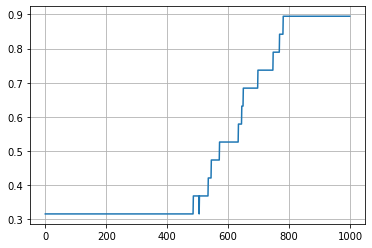

In [36]:
plt.plot(accuracy_sequence)
plt.grid()
print('Prediction = sigmoid(a* pets + b * mobile_home + c * tenure + d * yrs_educ + f)')
print('a = {:.4f}'.format(a))
print('b = {:.4f}'.format(b))
print('c = {:.4f}'.format(c))
print('d = {:.4f}'.format(d))
print('f = {:.4f}'.format(f))

<hr style="border:3px solid orange"> </hr>

## Compare to logistic regression:

This is actually the exact form of logistic regression.

The only difference is our solving methods.

In [46]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit

logit_model = logit("evacuated ~ pets + mobile_home + tenure + years_educ", evac_df).fit()

         Current function value: 0.236149
         Iterations: 35


/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
# Parameters:
nn_params = [round(x, 3) for x in [a, b, c, d, f]]
print('NN Params: {}'.format(nn_params))

logit_model.summary()

NN Params: [0.132, 0.822, 0.45, 0.124, -0.65]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              evacuated   No. Observations:                   19
Model:                          Logit   Df Residuals:                       14
Method:                           MLE   Df Model:                            4
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.6213
Time:                        19:58:10   Log-Likelihood:                -4.4868
converged:                      False   LL-Null:                       -11.849
Covariance Type:            nonrobust   LLR p-value:                  0.005306
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.4513      2.668      0.544      0.586      -3.778       6.680
pets          -35.4092   4.35e+07  -8.13e-07      1.000   -8.53e+07    8.53e+07
mobile_home    38.1197   4.35e+07   8.75e-07      1.000   -8.53e+07    8.53e+07
tenure         -0.2737      2.653     -0.103      0.918      -5.474       4.927
years_educ     -8.0213      7.056     -1.137      0.256     -21.850       5.808
===============================================================================

Possibly complete quasi-separation: A fraction 0.32 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [28]:
X = evac_df[['pets', 'mobile_home', 'tenure', 'years_educ']]
logistic_preds = (logit_model.predict(X)>0.5).astype(int)

In [29]:
logistic_acc = np.mean([p == t for p, t in zip(evac_df['evacuated'].values, logistic_preds)])
print('Logistic Accuracy: {:.4f}'.format(logistic_acc))

Logistic Accuracy: 0.8421


<hr style="border:3px solid orange"> </hr>

# Neural Networks in Scikit-Learn

Documentation for "Multi Layer Perceptron" model:

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

Consider the flattened Fashion MNIST:

|  Label  |  Description  |
|:-------:|:-------------:|
|    0    |  T-shirt/top  |
|    1    |  Trouser      |
|    2    |  Pullover     |
|    3    |  Dress        |
|    4    |  Coat         |
|    5    |  Sandal       |
|    6    |  Shirt        |
|    7    |  Sneaker      |
|    8    |  Bag          |
|    9    |  Ankle boot   |

In [48]:
# Load fashion MNIST from TF datasets library.
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
# Wait for 4 downloads to finish.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

labels = ['tshirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']

In [49]:
# Need a 1D array of inputs, we have 2D arrays of inputs.
xf_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
# Transform/flatten x-test
xf_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

print(xf_train.shape)
print(xf_test.shape)

(60000, 784)
(10000, 784)


### Min max scaling


In [50]:
# Scale/Standardize the inputs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

xf_train = scaler.fit_transform(xf_train)

# Fit on test
xf_test = scaler.transform(xf_test)

In [51]:
# Load MLP classifier:
# Loss is not specified: For "MLPClassifier" defaults to cross-entropy.
mlp = MLPClassifier(hidden_layer_sizes=(40, 10), max_iter=100, alpha=0.0001,
                    solver='sgd', activation='logistic', batch_size=512,
                    verbose=10, random_state=1, learning_rate_init=0.01,
                    n_iter_no_change=10, tol=0.00001)

In [52]:
# Fit on data:
mlp.fit(xf_train, y_train)

Iteration 1, loss = 2.29967944
Iteration 2, loss = 2.26414768
Iteration 3, loss = 2.15123552
Iteration 4, loss = 1.90971050
Iteration 5, loss = 1.74506237
Iteration 6, loss = 1.64231888
Iteration 7, loss = 1.53160678
Iteration 8, loss = 1.41081777
Iteration 9, loss = 1.30645152
Iteration 10, loss = 1.22290149
Iteration 11, loss = 1.15578467
Iteration 12, loss = 1.10156733
Iteration 13, loss = 1.05724842
Iteration 14, loss = 1.02006216
Iteration 15, loss = 0.98753362
Iteration 16, loss = 0.95703716
Iteration 17, loss = 0.92680992
Iteration 18, loss = 0.89597484
Iteration 19, loss = 0.86547862
Iteration 20, loss = 0.83629603
Iteration 21, loss = 0.80943435
Iteration 22, loss = 0.78528181
Iteration 23, loss = 0.76379822
Iteration 24, loss = 0.74472114
Iteration 25, loss = 0.72759267
Iteration 26, loss = 0.71205436
Iteration 27, loss = 0.69773414
Iteration 28, loss = 0.68489598
Iteration 29, loss = 0.67260365
Iteration 30, loss = 0.66125981
Iteration 31, loss = 0.65041878
Iteration 32, los

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', batch_size=512,
              hidden_layer_sizes=(40, 10), learning_rate_init=0.01,
              max_iter=100, random_state=1, solver='sgd', tol=1e-05,
              verbose=10)

Text(0.5, 1.0, 'Loss Curve')

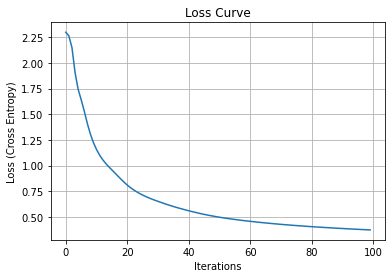

In [53]:
plt.plot(mlp.loss_curve_)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Loss Curve')

In [54]:
print("Training set score: {:.4f}".format(mlp.score(xf_train, y_train)))
print("Test set score: {:.4f}".format(mlp.score(xf_test, y_test)))

test_preds = mlp.predict(xf_test)

conf_mat1 = pd.DataFrame(confusion_matrix(y_test, test_preds), columns=labels, index=labels)

conf_mat1

Training set score: 0.8710
Test set score: 0.8548


,tshirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,boot
tshirt,827,1,13,45,1,2,98,0,13,0
trouser,2,955,7,27,4,0,4,0,1,0
pullover,19,1,757,8,132,2,77,0,4,0
dress,29,16,2,869,38,1,42,0,3,0
coat,0,1,93,30,805,1,68,0,2,0
sandal,0,0,0,1,0,914,0,51,4,30
shirt,164,3,100,28,99,1,585,0,20,0
sneaker,0,0,0,0,0,28,0,938,0,34
bag,2,1,4,10,3,7,22,4,947,0
boot,0,0,0,0,0,7,0,41,1,951


In [55]:
# Let's make a deeper model:
# Note we up the iterations to 200.  A deeper model may take longer to optimize.
mlp2 = MLPClassifier(hidden_layer_sizes=(50, 30, 10), max_iter=200, alpha=0.0001,
                     solver='sgd', activation='logistic', batch_size=512,
                     verbose=10, random_state=1, learning_rate_init=0.005,
                     n_iter_no_change=10, tol=0.00001)
mlp2.fit(xf_train, y_train)

Iteration 1, loss = 2.31275793
Iteration 2, loss = 2.30230847
Iteration 3, loss = 2.30196081
Iteration 4, loss = 2.30169710
Iteration 5, loss = 2.30139956
Iteration 6, loss = 2.30101761
Iteration 7, loss = 2.30062048
Iteration 8, loss = 2.30016464
Iteration 9, loss = 2.29957663
Iteration 10, loss = 2.29893030
Iteration 11, loss = 2.29805636
Iteration 12, loss = 2.29694126
Iteration 13, loss = 2.29547206
Iteration 14, loss = 2.29341137
Iteration 15, loss = 2.29044270
Iteration 16, loss = 2.28598679
Iteration 17, loss = 2.27886064
Iteration 18, loss = 2.26667277
Iteration 19, loss = 2.24445075
Iteration 20, loss = 2.20179327
Iteration 21, loss = 2.12355945
Iteration 22, loss = 2.01054407
Iteration 23, loss = 1.89956003
Iteration 24, loss = 1.81995646
Iteration 25, loss = 1.76938805
Iteration 26, loss = 1.73674246
Iteration 27, loss = 1.71456045
Iteration 28, loss = 1.69845797
Iteration 29, loss = 1.68601980
Iteration 30, loss = 1.67545177
Iteration 31, loss = 1.66534502
Iteration 32, los

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', batch_size=512,
              hidden_layer_sizes=(50, 30, 10), learning_rate_init=0.005,
              random_state=1, solver='sgd', tol=1e-05, verbose=10)

Text(0.5, 1.0, 'Loss Curve')

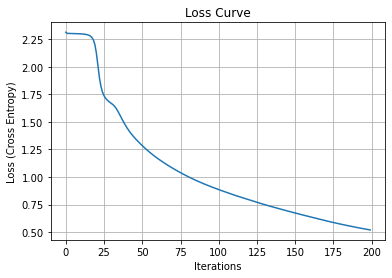

In [56]:
plt.plot(mlp2.loss_curve_)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Loss Curve')

<hr style="border:3px solid orange"> </hr>

### Some Notes on Parameter Space

> You can see that with the deeper model, the optimal loss curve shows our iterative point trajectory THROUGH the parameter space. While it is technically smooth, the more bumpy it is the MORE SADDLES exist in our space. This is exceptionally apparent with very high dimensional parameter space models.

> Also to note is the small variations at the end. This may mean we are near a (probably local and not global) optimal solution but are jumping around due to our mini-batch variation. We may consider lowering the learning rate to better converge to that optimal point.

<hr style="border:3px solid orange"> </hr>

In [57]:
print("Training set score: {:.4f}".format(mlp2.score(xf_train, y_train)))
print("Test set score: {:.4f}".format(mlp2.score(xf_test, y_test)))

test2_preds = mlp2.predict(xf_test)

conf_mat2 = pd.DataFrame(confusion_matrix(y_test, test2_preds), columns=labels, index=labels)
conf_mat2

Training set score: 0.8147
Test set score: 0.8090


,tshirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,boot
tshirt,858,1,13,63,7,1,44,0,13,0
trouser,4,945,8,36,2,0,3,0,2,0
pullover,23,0,745,15,144,0,68,0,5,0
dress,42,7,6,864,36,0,37,0,8,0
coat,0,0,138,36,800,0,23,0,3,0
sandal,0,0,0,0,0,909,0,65,9,17
shirt,226,1,188,49,337,0,178,0,21,0
sneaker,0,0,0,0,0,42,0,907,0,51
bag,1,0,1,7,11,10,14,3,952,1
boot,0,0,0,0,0,16,0,51,1,932


<hr style="border:3px solid orange"> </hr>

# Neural Networks in TensorFlow / Keras

Documentation:

https://www.tensorflow.org/


Tutorials:

https://www.tensorflow.org/tutorials/keras/classification

### Setup some parameters

In [58]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

#-------------------------
# Set some hyper parameters
#-------------------------

# Total number of training epochs
epochs = 15

# Training batch size
batch_size = 512

# The optimization initial learning rate
learning_rate = 0.0025

# Hidden layer sizes
h1 = 50
h2 = 30
h3 = 10
# We need to setup the final labels count.
final_count = 10

#-------------------------
# Set some regular parameters
#-------------------------

# x-data feature size
n_features = xf_train.shape[1]

### Setup the model

> Note that we set a function for random initialization of parameters. We may also try others:

See left menu here: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomUniform

In [59]:
# Initialize a "sequential model" with tf.keras
model = tf.keras.Sequential()

# Add layers sequentially
model.add(Dense(h1, input_shape=(n_features,)))
model.add(Dense(h2))
model.add(Dense(h3))

# The following is probably more common to see these days: each layer is followed by an activation function.
#.   This allows sequential features to have the ability to be non-linear.
# model.add(Dense(h1, activation='relu', kernel_initializer='random_normal', input_shape=(n_features,)))
# model.add(Dense(h2, activation='relu', kernel_initializer='random_normal'))
# model.add(Dense(h3, activation='relu', kernel_initializer='random_normal'))


# Add final output
model.add(Dense(final_count, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 41,200
Trainable params: 41,200
Non-trainable params: 0
_________________________________________________________________


### Total parameter check:

The above model shows 39,250 + 1,530 + 310 + 110 = 41,200 total trainable parameters. Is this right?

Consider that the first layer goes from 784 features to 50 features. Then the first layer should have 784*50 +50 = 39,250 weights. This means (784*50 = 39,200 multiplicative weights) AND (50 additive biases for each target features).

The same for each resulting layer:

 - (50*30) + 30 = 1,530 weights and biases.
 
 - (30*10) + 10 = 310 weights and biases.
 
 - (10*10) + 10 = 110 weights and biases.

### Setup the loss, optimizer

 - Probably use the ADAM optimizer (adaptive momentum).
 - For the loss, stick with cross entropy.

In [60]:
# Setup model with ADAM optimization and cross entropy loss.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 41,200
Trainable params: 41,200
Non-trainable params: 0
_________________________________________________________________


### Fit/Train the model!

In [61]:
model_logs = model.fit(xf_train, y_train,
                       epochs=epochs, batch_size=batch_size,
                       validation_data=(xf_test, y_test), verbose=1)

Epoch 1/15
118/118 [==============================] - 1s 5ms/step - loss: 1.0932 - accuracy: 0.5684 - val_loss: 0.6609 - val_accuracy: 0.7748
Epoch 2/15
118/118 [==============================] - 0s 3ms/step - loss: 0.5587 - accuracy: 0.8119 - val_loss: 0.5421 - val_accuracy: 0.8152
Epoch 3/15
118/118 [==============================] - 0s 3ms/step - loss: 0.5025 - accuracy: 0.8304 - val_loss: 0.6088 - val_accuracy: 0.7762
Epoch 4/15
118/118 [==============================] - 0s 3ms/step - loss: 0.4778 - accuracy: 0.8373 - val_loss: 0.5107 - val_accuracy: 0.8241
Epoch 5/15
118/118 [==============================] - 0s 3ms/step - loss: 0.4606 - accuracy: 0.8420 - val_loss: 0.5025 - val_accuracy: 0.8255
Epoch 6/15
118/118 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.8443 - val_loss: 0.4831 - val_accuracy: 0.8327
Epoch 7/15
118/118 [==============================] - 0s 3ms/step - loss: 0.4448 - accuracy: 0.8464 - val_loss: 0.4810 - val_accuracy: 0.8320
Epoch 

### Evaluate the model

In [62]:
# evaluate the model
test_loss, test_acc = model.evaluate(xf_test, y_test, verbose=1)
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

313/313 [==============================] - 0s 657us/step - loss: 0.5008 - accuracy: 0.8190
Test Loss: 0.5008, Test Accuracy: 0.8190


> Note the speed of evaluation. X-test has 10,000 samples in it. Model set to compute on batches/steps of 256.


In [63]:
tf_test_probs = model.predict(xf_test)

# predict will give a 10000 X 10 array of probabilities
# Need to convert it to a 10000 X 1 where we find ARG max for each row.

tf_test_preds = np.argmax(tf_test_probs, axis=1)

conf_mat_tf = pd.DataFrame(confusion_matrix(y_test, tf_test_preds), columns=labels, index=labels)
conf_mat_tf

,tshirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,boot
tshirt,723,4,4,64,6,2,183,0,13,1
trouser,4,946,2,31,6,0,9,0,2,0
pullover,19,3,417,13,254,0,281,0,13,0
dress,21,10,1,876,29,0,59,1,3,0
coat,0,1,17,38,798,1,137,0,8,0
sandal,0,0,0,1,0,935,0,46,3,15
shirt,98,2,36,46,105,0,694,0,19,0
sneaker,0,0,0,0,0,43,0,914,0,43
bag,2,1,2,11,3,11,28,4,937,1
boot,0,0,0,0,0,14,1,35,0,950


### What did we log/record?

In [64]:
model_logs.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

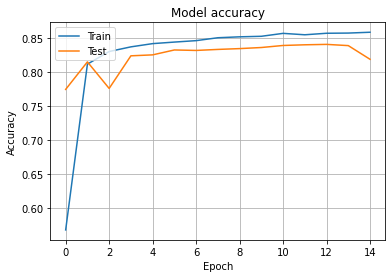

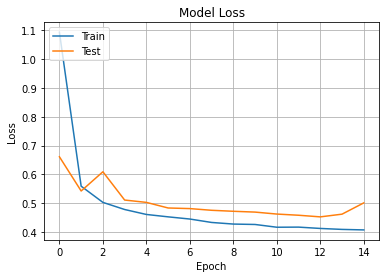

In [65]:
# Plot accuracy
plt.plot(model_logs.history['accuracy'])
plt.plot(model_logs.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()
# plot loss
plt.plot(model_logs.history['loss'])
plt.plot(model_logs.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Deeper TF Dense Network w/ Dropout

Now let's train with more/wider layers with dropout.

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

#-------------------------
# Set some hyper parameters
#-------------------------

# Total number of training epochs
epochs = 20

# Training batch size
batch_size = 512

# The optimization initial learning rate
learning_rate = 0.05

# Hidden layer sizes
h_layer_seq = [200, 100, 50, 30, 10]
# We need to setup the final labels count.
final_count = 10

# TO NOTE: if it is a binary class, we can just do final_count=1 (just a probability of being class 1)

#-------------------------
# Set some regular parameters
#-------------------------

# x-data feature size
n_features = xf_train.shape[1]

In [75]:
# Initialize a "sequential model" with tf.keras
model = tf.keras.Sequential()

# Add layers sequentially
for h_ix, h_num in enumerate(h_layer_seq):
    if h_ix == 0:
        # Need to set input Dimensions
        model.add(Dense(h_num, activation='relu', kernel_initializer='random_normal', input_shape=(n_features,)))
    else:
        model.add(Dense(h_num, activation='relu', kernel_initializer='random_normal'))
        # Add dropout!
        model.add(Dropout(rate=0.2))


# Add final output
model.add(Dense(final_count, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                1530      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)               

In [76]:
import os
import datetime

In [68]:
# Setup / Compile model
# Setup model with ADAM optimization and cross entropy loss.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



# Can setup a custom one:
my_optmizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                                       epsilon=1e-07, amsgrad=False, name='Adam')

# Note: For a binary output and when the final_count output ==1, then use 'binary_crossentropy'.
# FOR HOMEWORK!

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)               

In [69]:
# Fit model
model_logs = model.fit(xf_train, y_train,
                       epochs=epochs, batch_size=batch_size,
                       validation_data=(xf_test, y_test), verbose=1)

Epoch 1/20
118/118 [==============================] - 1s 6ms/step - loss: 1.8880 - accuracy: 0.2281 - val_loss: 1.4482 - val_accuracy: 0.2477
Epoch 2/20
118/118 [==============================] - 1s 5ms/step - loss: 1.4681 - accuracy: 0.3146 - val_loss: 1.1626 - val_accuracy: 0.3587
Epoch 3/20
118/118 [==============================] - 1s 5ms/step - loss: 1.2819 - accuracy: 0.4176 - val_loss: 1.0682 - val_accuracy: 0.5188
Epoch 4/20
118/118 [==============================] - 1s 5ms/step - loss: 1.1527 - accuracy: 0.4957 - val_loss: 0.8134 - val_accuracy: 0.6066
Epoch 5/20
118/118 [==============================] - 1s 6ms/step - loss: 0.9473 - accuracy: 0.5408 - val_loss: 0.7122 - val_accuracy: 0.6138
Epoch 6/20
118/118 [==============================] - 1s 5ms/step - loss: 0.8545 - accuracy: 0.5991 - val_loss: 0.6767 - val_accuracy: 0.7211
Epoch 7/20
118/118 [==============================] - 1s 5ms/step - loss: 0.7583 - accuracy: 0.6972 - val_loss: 0.5569 - val_accuracy: 0.8096
Epoch 

### TO NOTE

> Notice how the accuracy of the validation (our test set) is much higher than our train set!


### Evaluate:

In [70]:
# evaluate the model
test_loss, test_acc = model.evaluate(xf_test, y_test, verbose=1)
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

313/313 [==============================] - 0s 699us/step - loss: 0.3878 - accuracy: 0.8699
Test Loss: 0.3878, Test Accuracy: 0.8699


In [71]:
tf_test_probs = model.predict(xf_test)

# predict will give a 10000 X 10 array of probabilities
# Need to convert it to a 10000 X 1 where we find ARG max for each row.

tf_test_preds = np.argmax(tf_test_probs, axis=1)

conf_mat_tf = pd.DataFrame(confusion_matrix(y_test, tf_test_preds), columns=labels, index=labels)
conf_mat_tf

,tshirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,boot
tshirt,864,3,10,20,2,0,96,0,5,0
trouser,2,968,1,25,1,0,3,0,0,0
pullover,10,0,844,7,47,0,91,0,1,0
dress,27,11,6,881,33,0,38,0,4,0
coat,0,0,196,37,686,0,78,0,3,0
sandal,0,0,0,0,0,939,0,28,1,32
shirt,186,1,97,15,50,0,643,0,8,0
sneaker,0,0,0,0,0,13,0,942,1,44
bag,1,0,8,3,5,2,10,3,968,0
boot,1,0,0,0,0,3,0,32,0,964


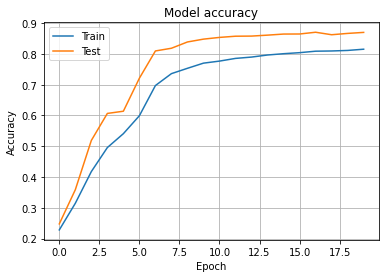

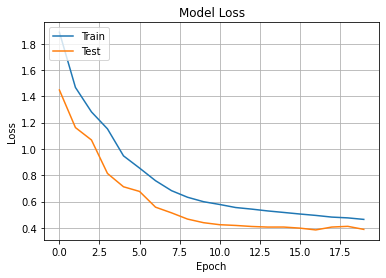

In [72]:
# Plot accuracy
plt.plot(model_logs.history['accuracy'])
plt.plot(model_logs.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()
# plot loss
plt.plot(model_logs.history['loss'])
plt.plot(model_logs.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

### How do we get the weights?

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)               

In [74]:
##. TODO: change name of layer below to match above.

my_layer = model.get_layer(name='dense_95')

# Get the weights
w = my_layer.get_weights()

# List of numpy arrays: [mult_weights, bias_wieghts]
multiplicative_w = w[0]
bias_w = w[1]

print(multiplicative_w.shape)
print(bias_w.shape)

bias_w

ValueError: No such layer: dense_95.

# Lab!!! Make your own NN in Tensorflow and arrive at the accuracy:

### Ideas:

- While it is common for NN layers to go from more features to less features as data progresses through, what happens if we go from small features to more? e.g. hidden layer nums = [3, 50, 100, 200]

- What happens if Dropout is too large?